<center>
<img src="../../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: Топорнин Дмитрий Дмитриевич, @wild_dima.

# Визуализация больших объемов географиских данных

Выбирая себе kernel для проекта, наткнулся на один интересный датасет: данные об измерениях уровня радиации волонтерами в разных частях света. Данных достаточно много для стандартных домашних комьютеров - 10гб и 80 миллионов строк - https://www.kaggle.com/safecast/safecast.

Для начала я использовал привычный geopandas, но что-то пошло не так и примерно так выглядела используемая питоном память:

<img src="./img/memory.png" alt='memory'/>

Поэтому я попытался пойти другим путем, задавишись целью сэкономить память и время. Для это я решил воспользоваться библиотекой [bcolz](https://github.com/Blosc/bcolz). Она написана на C, а python лишь использует ее обертку, поэтому она очень эффективна по памяти. По сути, это просто очень удобный контейнер для данных, который умеет делать простейшие преобразование, вроде `append`, обращению к столбцам, строкам. Самым главным его преемуществом является возможность сжимать данные.

Подключим нужны нам библиотеки:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt
import csv
import bcolz
import time

from scipy import ndimage
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm_notebook
from IPython.display import clear_output, display
from shapely.geometry import Point

Так же добавим библиотек для просмотра задействованной памяти:

In [2]:
import os
import psutil
process = psutil.Process(os.getpid())

И заодно добавим метод, которые будет выводить количество задействованной оперативной памяти:

In [3]:
def print_memory_usage():
    print("{} mb".format(process.memory_info().rss/8/100/1000))

In [4]:
print_memory_usage()

175.3344 mb


Данные, которые я использовал слишком большие, для репозитория, но вы их можете найти [здесь](https://www.kaggle.com/safecast/safecast/data).

In [5]:
DATA_PATH = '/Users/dmitrijtopornin/.kaggle/datasets/safecast/safecast/measurements.csv'

## Чтение данных

Инициализируем bcolz массив из нулей, и сделаем его двумерным:

In [6]:
meas = bcolz.zeros((0, 2), dtype='float32')

In [7]:
print_memory_usage()

175.488 mb


Поскольку основной моей целью является экономия памяти, то я решил подойти к этому вопросу в лоб. Это далеко не самый эффективный способ по скорости, поэтому для тех, кто может жонглировать планками оперативки можно воспользоваться хоть pandas'ом, чтобы прочитать это. Основные проблемы по памяти мне доставил geopandas.

В этих данных есть пропуски, поэтому если я обернул преобразование во float в try-catch, чтобы отловить их и проигнорировать(у нас 80 миллионов данных, не будем жадничать):

In [8]:
with open(DATA_PATH) as file:
    rows = csv.reader(file)
    next(rows)
    for row in tqdm_notebook(rows):
        try:
            meas.append([float(row[1]), float(row[2])])
        except ValueError:
            pass

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [9]:
print_memory_usage()

392.48384000000004 mb


Прочитав 80 миллионов данных мы потратили только 150 мб оперативной памяти, что явно лучше предыдущего моего результата.

## Визуализация

### Визуализация всех точек

Используем `geopandas`, для отрисовки проекции карты

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

И отрисуем 80 миллионов точек в лоб. `%%time`, чтобы засечь время тут не сработает, поскольку вычислять cell он закончит быстро, а вот отрисовывать это он будет немного дольше. Поэтому используем немного странный способ, однако он намного более показательный:

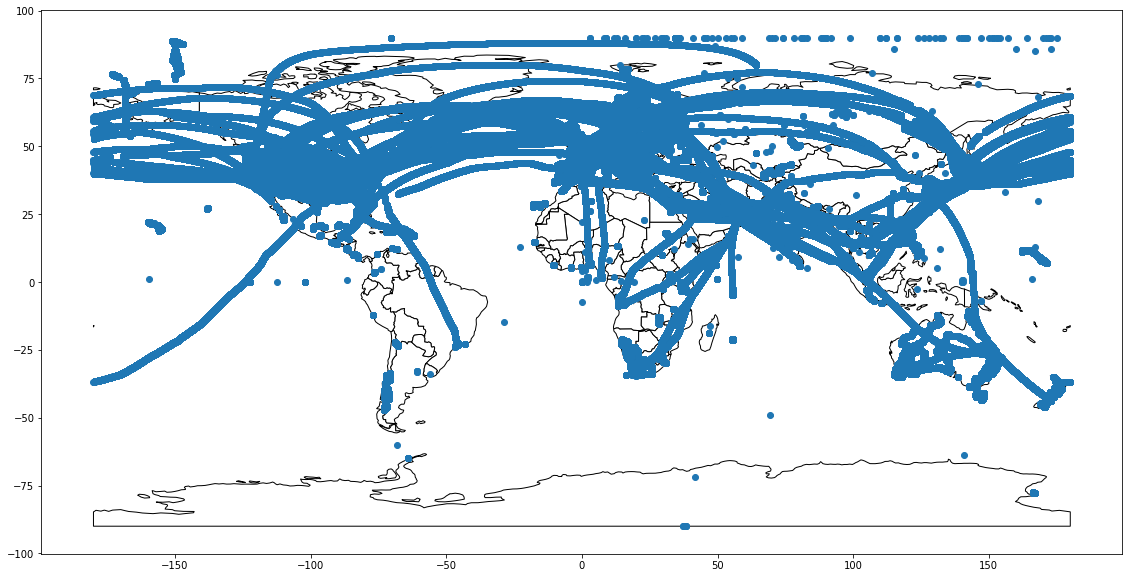

In [11]:
import datetime
start = datetime.datetime.now()
ax = world.plot(color='white', edgecolor='black', figsize=(20,10))
ax.scatter(meas[:, 1], meas[:, 0])

In [12]:
print(datetime.datetime.now() - start)

0:08:52.726463


Это было долго.

### Heatmap

#### Обработка данных

Скорее всего, для цели, в рамках которой нужно просмотреть большое количество данных, отрисовка их по одному имеет мало смысла. Здесь в большей степени хочется посмотреть на то, где наибольшее скопленее этих точек. Первое, что приходит в голову - кластеризовать с помощью какого-нибудь алгоритма из этого курса, однако я пробовал - это долго. Скорее хочется взглянуть на что-то, вроде heatmap'а.

Для этого, всеми нами любимый numPy предоставляет нам возможность создать гистограмму в 2d:

In [13]:
%%time
heatmap, x, y = np.histogram2d(meas[:, 0], meas[:, 1], bins=(20, 20))

CPU times: user 6.54 s, sys: 3.85 s, total: 10.4 s
Wall time: 11 s


Здесь y, x - координаты, а bins - количество точек, из которых будет состоять гистограмма. Гистограмма (5, 5) будет предсказуемо тяжело интерпретироваться, поскольку после сглаживания получит примерно такой вид:

<img src="./img/hist5x5.png" alt='hist 5 5'/>

Чтобы немного сгладить наши данные прологарифмируем их, незабыв добавить 1, чтобы не получить логарифм нуля.

In [14]:
heatmap = np.log(heatmap+1)

Отлично, теперь у нас есть heatmap, который даже можно отрисовать:

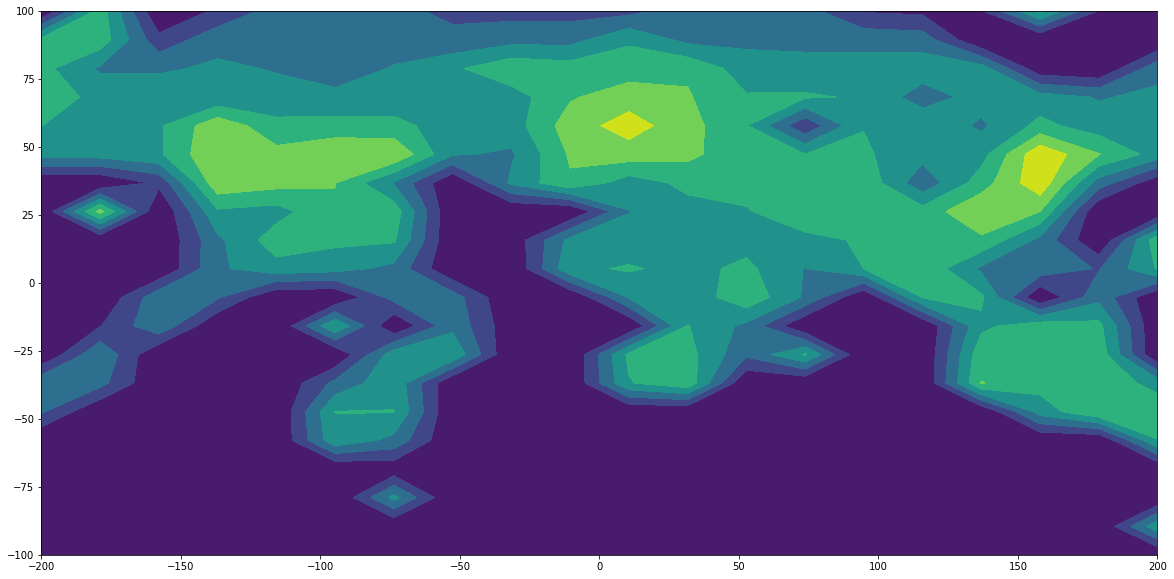

In [15]:
plt.figure(figsize=(20,10))
contour = plt.contourf(heatmap, extent=[-200, 200, -100, 100])
plt.show()

Он выглядит неплохо, однако стоит попробовать сгладить его с использованием какого-нибудь фильтра из `ndimage`, который идет вместе с `scipy`. Их там очень много и я попробовал многие, но все таки для этих целей лучше всего подойдет классический `gaussian_filter`(прочитать о нем подробнее можно, например, [здесь](https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm)).

Собственно в использовании он прост как палка - даем хитмап, выбираем сигму и готово:

In [16]:
filtered_heatmap = ndimage.filters.gaussian_filter(heatmap, 1)

#### Визуализация

Отрисуем эти данные с использованием `countourf`:

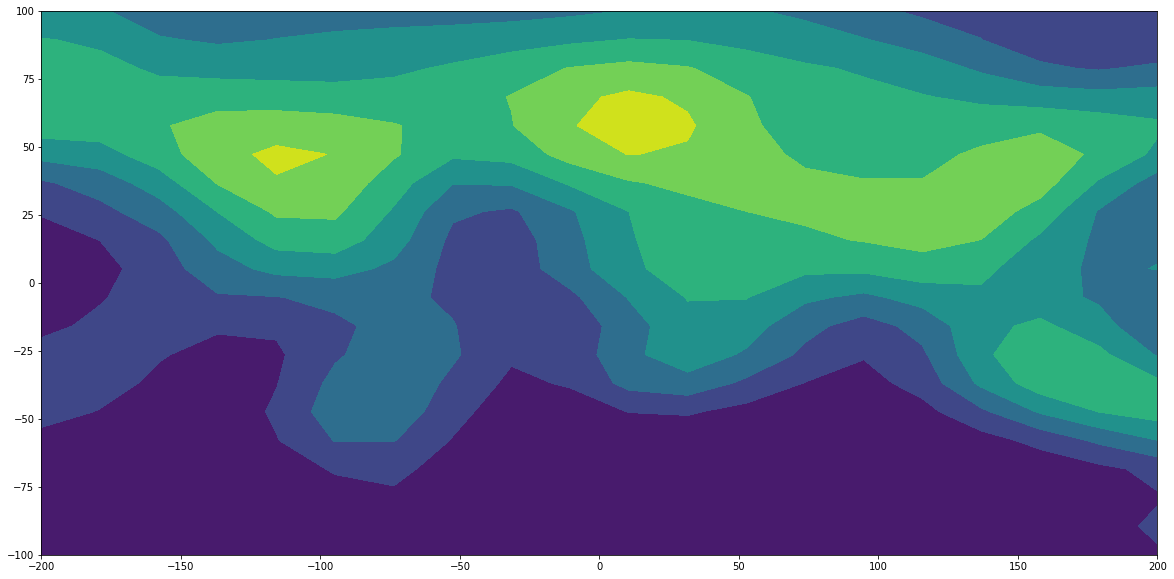

In [17]:
plt.figure(figsize=(20,10))
contour = plt.contourf(filtered_heatmap, extent=[-200, 200, -100, 100])
plt.show()

Красота! Теперь уже стало понятно, в каких местах данных больше всего и можно определить примерно, как выглядит карта измерений. Однако для полноты картины стоит совместить ее с картой мира. Для этого возмем проекцию, которую мы использовали раньше, и совместим ее с полученным контуром в результате последнего преобразования:

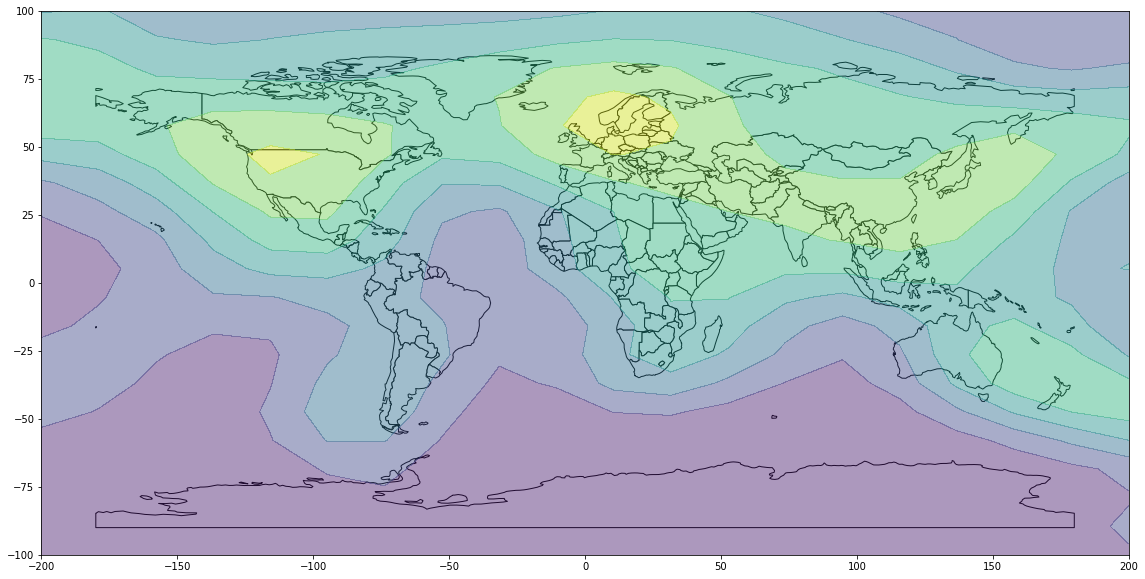

In [18]:
base = world.plot(figsize=(20,10), color='white', edgecolor='black')
base.contourf(contour, alpha=0.45)
plt.show()

Но мне недает покоя мысль, что мы читали файл 10 минут. Конечно, ускорить это дело непросто, однако можно попытаться получить некоторую информацию на стадии чтения. Например перерисовывать карту, по мере поступления данных.
Для обернем все, что мы сделали до этого в функцию. Добавим только вызов функции `clear_output` из `IPython.display` для придания некоторой интерактивности нашей отрисовке:

## Визуализация в процессе чтения файла

In [19]:
def plot_heatmap_geo(data):
    heatmap, x, y = np.histogram2d(data[:, 0], data[:, 1], bins=(20, 20))
    heatmap = np.log(heatmap+1)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'));
    base = world.plot(figsize=(20,10), color='white', edgecolor='black');
    filtered_heatmap = ndimage.filters.gaussian_filter(heatmap, 1);
    contour = plt.contourf(filtered_heatmap, extent=[-200, 200, -100, 100], alpha=0.45)
    base.contourf(contour, alpha=0.45);
    clear_output(wait=True)
    display(plt.gcf())
    time.sleep(1)

И будем перерисовывать карту, например, каждые 50 тысяч точек. При желании это число можно изменить, но это число показалось мне достаточно удобным:

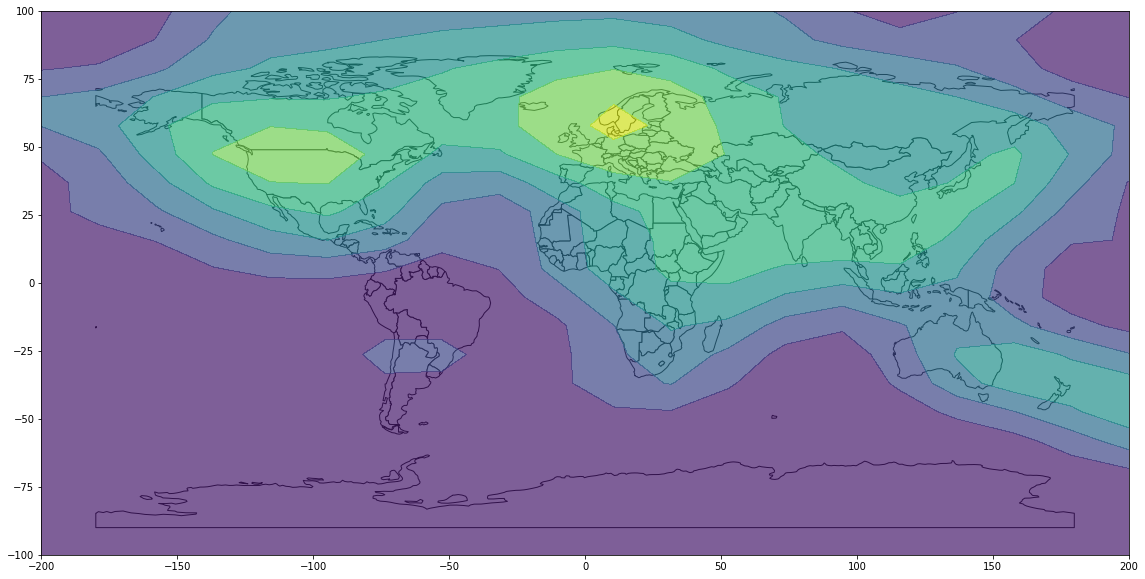

In [ ]:
meas2 = bcolz.zeros((0, 2), dtype='float32')

with open(DATA_PATH) as file:
    rows = csv.reader(file)
    next(rows)
    for row in rows:
        try:
            meas2.append([float(row[1]), float(row[2])])
        except ValueError:
            pass
        if meas2.shape[0] % 50000 == 0:
            plot_heatmap_geo(meas2);

plot_heatmap_geo(meas2)

В результате получим что-то вроде этого (это гифка):

<img src="./img/map_overwriting.gif" alt='map'/>

## Заключение

Существенный недостаток доанного подхода - достаточно долгое чтение файла. Тот же pandas справился бы с чтением в несколько раз быстрее, однако он затратил бы больше памяти, и не было бы возможности отрисовывать heatmap динамически при получении новых данных.